## EDA 

Welkom bij de eda voor het herkennen van de kanker Colorectal Cancer in weefsel slices.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np



# data inladen
p = Path("C:/Users/Laris/Downloads/idc_regular")  

# patient bestanden inladen
patient_names = [os.path.basename(x) for x in p.iterdir() if x.is_dir()]
print(f"Amount of patients: {len(patient_names)}")

#slice samples paden opslaan
file_names = []
pos_amount = 0
neg_amount = 0

for f in patient_names:
    ongezond = p.joinpath(f, "1") # pad naar ongezonde slices 
    gezond = p.joinpath(f, "0") # pad naar gezonde slices

    #alle slice paden verzamelen
    postive_file_names = [f for f in ongezond.iterdir() if f.is_file()]
    negative_file_names = [f for f in gezond.iterdir() if f.is_file()]

    #totale hoeveelheid van gezond of ongezonde slices 
    pos_amount += len(postive_file_names)
    neg_amount += len(negative_file_names)

    #zorgt voor 1 gezamelijke list met de list met alle paden omstebeurten steeds.
    #(achteraf kan dit beter in een pandas df, maar tijd te kort)
    file_names.append(postive_file_names)
    file_names.append(negative_file_names)
print(f"Amount of postive files {pos_amount}. Amount of negative files {neg_amount}")


Amount of patients: 279
Amount of postive files 78786. Amount of negative files 198738


De data bestaat uit 279 patienten, met ongeveer 80000 slices aan kankerhoudende cellen en bijna 200000 aan gezondweefsel.

**Missende data**  
Of alle fragmenten de zelfde afmetingen hebben.

In [259]:
from PIL import Image

image_sizes = []
totalw = 0
totalh = 0
total = 0
images = []
file_names_new = []


for i in range(len(file_names)):
    imges = []
    files = []
    #door alle bestandpaden
    for file_name in file_names[i]:
        with Image.open(file_name) as img:
            width, height = img.size
            totalw += width
            totalh += height
            total += 1

            # grootte van 50.0 x 50.0 nodig
            if width == 50.0 and height == 50.0:
                # prep image voor een array
                img = img.convert('L')
                image_array = np.array(img) / 255.0
                image_array = np.expand_dims(image_array, axis=0) 
                
                #voor de list in list
                imges.append(image_array)
                files.append(file_name)
                
    # maakt de list in list structuur weer
    file_names_new.append(files) 
    images.append(imges)
            

# Print all image sizes
print(f"Average size: {round(totalw/total,3)}x{round(totalh/total,3)}")



Average size: 49.99x49.817


De gemiddelde grootte van de afbeeldingen is niet 50.0*50.0. Maar dit is wel de verwachtte grootte. Dus afbeeldingen kleiner dan worden niet meegenomen naar het model.

**Hoeveel uitsneden van gezond en van ongezond weefsel hebben we en wat is de verhouding tussen deze twee?**


In [232]:
print(f"Er zijn {pos_amount} uitsnedes van ongezond weefsel\nEr zijn {neg_amount} uitsnedes van gezond weefsel")


Er zijn 78786 uitsnedes van ongezond weefsel
Er zijn 198738 uitsnedes van gezond weefsel


Er is duidelijk een hogere hoeveelheid fragmenten van gezond weefsel aanwezig.

**Welk percentage van de totale scan is ongezond weefsel? Laat dit zien per patiënt en ten opzichte van het gemiddelde.**

Het gemiddelde percentage fragmenten ongezond weefsel en het percentage per patient wordt weergegeven in een grafiek en een tabel.

In [309]:
n_amount = 0
perc = []
total = 0
#bepalen van gemiddelde ongezond weefsel
for i in range(0, len(file_names), 2):
    scans = 0

    #positive
    scans += len(file_names[i])
    pos = scans

    #negative
    scans += len(file_names[i+1])

    perc.append(round(scans/pos,3))
    total += round(scans/pos,3)



<function matplotlib.pyplot.show(close=None, block=None)>

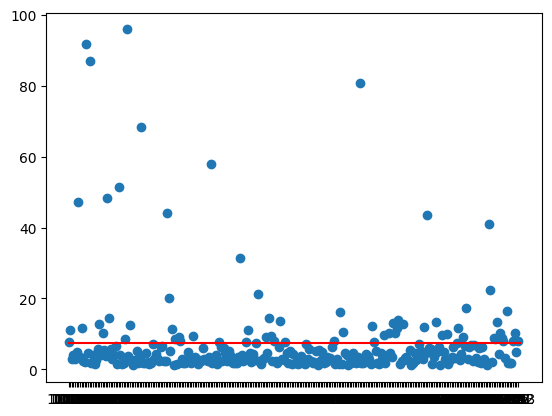

In [ ]:
avg = [total/len(patient_names)] * len(patient_names)

#plot
plt.scatter(patient_names, perc)
plt.plot(np.linspace(0, len(patient_names), len(patient_names)), avg, "-r")

plt.show

In [317]:
dif = []
#bepalen afwijkend van gemiddelde
for thing in perc:
    dif.append(avg[0] - thing)

df_avg = pd.DataFrame({"Percentage ongezond uitsnedes" : perc, "Afwijkende van gemiddelde": dif}, index = patient_names).sort_values("Percentage ongezond uitsnedes")
df_avg

,Percentage ongezond uitsnedes,Afwijkende van gemiddelde
14209,1.107,6.413989
9262,1.175,6.345989
12873,1.211,6.309989
9077,1.285,6.235989
12241,1.322,6.198989
...,...,...
12750,68.286,-60.765011
16085,80.708,-73.187011
10272,87.000,-79.479011
10268,91.696,-84.175011


Het is zichtbaar in de figuur dat een handje vol waarden ver boven het gemiddelde liggen. Er kan worden gekozen om deze er uit te halen. Maar de hoge hoeveelheid ongezond weefsels is ook belangrijk voor het model. Dus blijven ze erin.

**Welke gebieden van de totale scan (x-y-coördinaten) worden het meest geïnfecteerd met IDC? Kun je op basis van dit gegeven iets zeggen over de tumoren?**

Om dit visueel te maken worden de (x-y-coördinaten) geplot. En de dekkeing berekend.

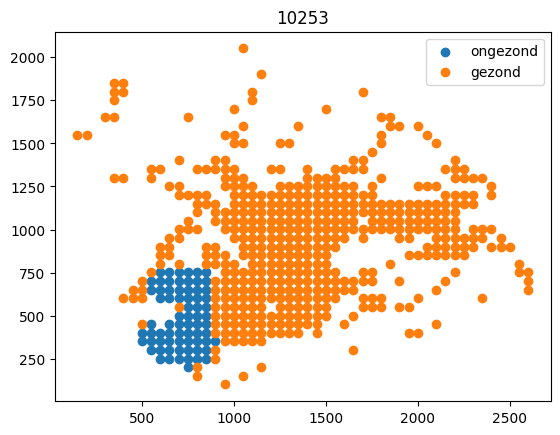

De fragmenten bedekken 25.07% van het totale oppervlakte


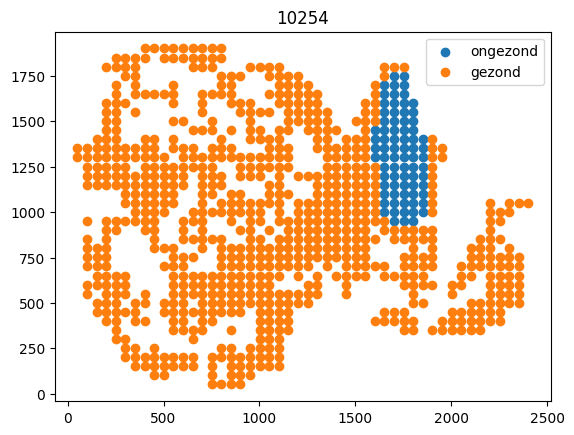

De fragmenten bedekken 44.39% van het totale oppervlakte


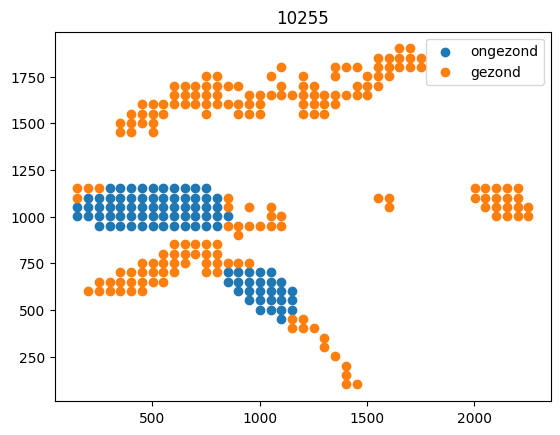

De fragmenten bedekken 11.97% van het totale oppervlakte


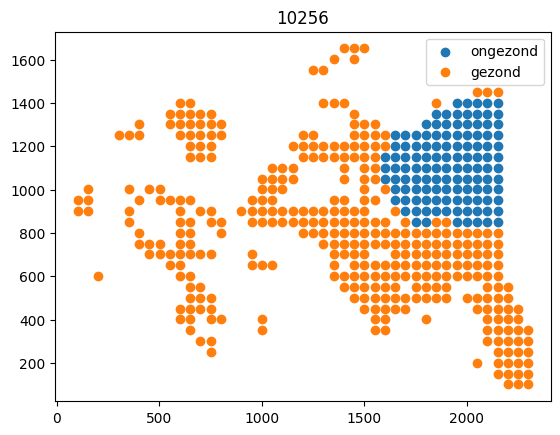

De fragmenten bedekken 25.73% van het totale oppervlakte


In [ ]:
"""
extraheren van x waarde uit file name

input:
    path: pad naar bestand

return:
    x: int met de x waarde
"""
def get_x(path):
    filename = os.path.basename(path)
    splited = filename.split("_")
    x = splited[2]
    x = x.replace("x", "")
    return int(x)

"""
extraheren van y waarde uit file name

input:
    path: pad naar bestand

return:
    y: int met de y waarde
"""
def get_y(path):
    filename = os.path.basename(path)
    splited = filename.split("_")
    y = splited[3]
    y = y.replace("y", "")
    return int(y)

"""
extraheren van x waarde uit file name

input:
    x: list met x waardes voor de patient
    y: list met y waarde voor de patient

return:
    percentage dat oppervlakte bedekt met slices
"""
def get_coveredsurface(x,y):
    sur = (max(x)-min(x)) * (max(y)-min(y))
    covered = (len(x) * 50 * 50) 
    return round(covered/sur*100,2)


totalcoverd = []
# door de eerst 4 patienten
for i in range(0,4*2,2):
    x = []
    y = []
    #positief
    for filename in file_names_new[i]:
        x.append(get_x(filename))
        y.append(get_y(filename))
    #plot ongezond weefsel
    plt.scatter(x, y, label = "ongezond")
    
    x = []
    y = []
    #negatief
    for filename in file_names_new[i+1]:
        x.append(get_x(filename))
        y.append(get_y(filename))

    #plot gezond weefsel
    plt.scatter(x, y, label = "gezond")
    plt.legend()
    plt.title(patient_names[round(i/2)])
    plt.show()
    print(f"De fragmenten bedekken {get_coveredsurface(x,y)}% van het totale oppervlakte")


Hierboven zijn dus alle losse fragmenten geplot, dit geeft dus de hele slice weer van de patient.

Je kan hier zien dat niet de hele slice zichtbaar is in de afbeeldingen. En dat dit heel verschillend kan zijn per patient. Dit was ook zichtbaar in de average lengte en hoogte. Je kan er voor kiezen om slices met een lage dekking er uit te laten. Maar dit geeft je ook weer minder data voor je module.

**visualisaties**

Er is gekozen voor grayscaling, want bij de kleuring gaat het vaak om de intensiteit. Deze is net zo zichtbaar als in een gray scaling.

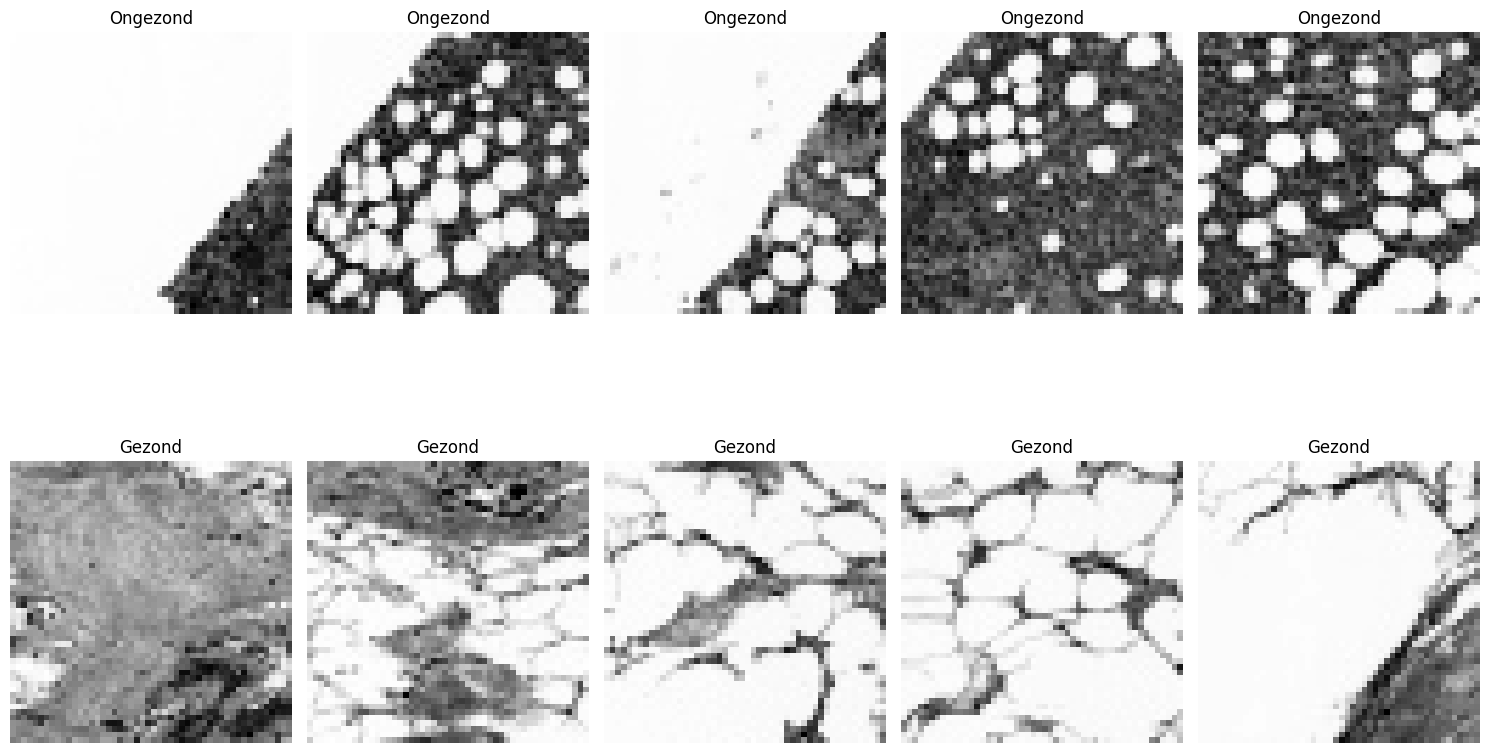

In [248]:
import matplotlib.pyplot as plt

num_images = 5

fig, axs = plt.subplots(2, num_images, figsize=(15, 10))

# Eerste set van afbeeldingen (Ongezond)
for i in range(num_images):
    axs[0, i].imshow(images[0][i][0], cmap='gray')  
    axs[0, i].axis('off')  
    axs[0, i].set_title(f"Ongezond")

# Tweede set van afbeeldingen (Gezond)
for i in range(num_images):
    axs[1, i].imshow(images[1][i][0], cmap='gray')  
    axs[1, i].axis('off') 
    axs[1, i].set_title(f"Gezond")

# Layout verbeteren
plt.tight_layout()
plt.show()


Data splitsing

In [312]:
gezond =[]
ongezond =[]

# splitsen van gezond en ongezond weefsel in apparte lijsten
for i in range(0, len(images), 2):
    ongezond.append(images[i])
    gezond.append(images[i+1])

testgezond = [item[0] for sublist in gezond for item in sublist]
testongezond = [item[0] for sublist in ongezond for item in sublist]


In [313]:
#maken van labels voor de lijsten
labelgezond = [0] * len(testgezond)
labelongezond = [1] * len(testongezond)

y = labelgezond + labelongezond
X = testgezond + testongezond



Trainen van model

In [314]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

#np array anders kapot
X = np.array(X)
y = np.array(y)
train_images, val_images, train_labels, val_labels = train_test_split(X, y, test_size=0.2, random_state=42)

#ander kapot
train_labels = to_categorical(train_labels, num_classes=2)
val_labels = to_categorical(val_labels, num_classes=2)

In [315]:
#opbouwen model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train het model
model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))


Epoch 1/10
6881/6881 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.7071 - loss: 0.5839 - val_accuracy: 0.7481 - val_loss: 0.5171
Epoch 2/10
6881/6881 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.7418 - loss: 0.5065 - val_accuracy: 0.7467 - val_loss: 0.4943
Epoch 3/10
6881/6881 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.7486 - loss: 0.4972 - val_accuracy: 0.7500 - val_loss: 0.4896
Epoch 4/10
6881/6881 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.7517 - loss: 0.4934 - val_accuracy: 0.7529 - val_loss: 0.4890
Epoch 5/10
6881/6881 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.7533 - loss: 0.4927 - val_accuracy: 0.7524 - val_loss: 0.4883
Epoch 6/10
6881/6881 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.7530 - loss: 0.4921 - val_accuracy: 0.7492 - val_loss: 0.4910
Epoch 7/10
6881/6881 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.7541 - loss: 0.4919 - val_accuracy: 0.7560 - val_loss: 0.4992
Epoch 8/10
6881/6881 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.7539 - loss: 0

Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Voorspelde label voor de eerste afbeelding: ongezond


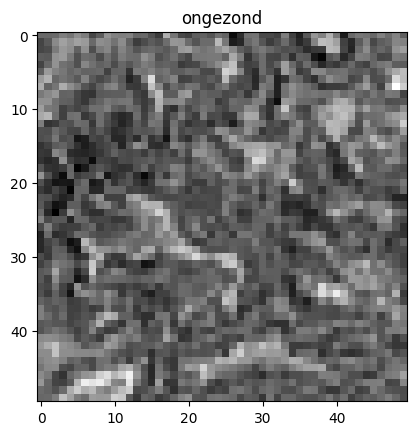

In [321]:
testimg = "testcancer.png"
image = Image.open(testimg).convert('L')  
image = image.resize((50, 50))  
image_array = np.array(image) / 255.0  
image_array = np.expand_dims(image_array, axis=0) 

predictions = model.predict(image_array)
labels = ["gezond", "ongezond"]

print(f"Voorspelde label voor de eerste afbeelding: {labels[predictions.argmax()]}")

plt.imshow(image_array[0], cmap='gray')
plt.title(labels[predictions.argmax()])
plt.show()

Dit is oorspronkelijk een afbeelding van het internet afgehaald dat kanker heeft, het wordt dus correct voorspelt.

Voor een model met alle afbeeldingen dat een afmeting hebben van 50.0x50.0 geeft een accuraatheid van 75%. Hier zit zeker mogelijkheid voor verbetering.

**Poging voor verbetering**

Als slices een lage bedekking hebben met ongezond weefsel.

In [328]:
x_partly = []
y_partly = []
images_partly = []

#lopen door de lijst in lijst
for collections in range(len(file_names_new)):
    imgs = []
    for file in range(len(file_names_new[collections])):
        x_partly.append(get_x(file_names_new[collections][file]))
        y_partly.append(get_y(file_names_new[collections][file]))

    #bedekkings percentage berekenen en vergelijken
    perc = get_coveredsurface(x_partly, y_partly)
    if perc >= 35.0:
        imgs.append(images[collections][file])
    images_partly.append(imgs)

In [ ]:

gezond =[]
ongezond =[]

# splitsen van gezond en ongezond weefsel in apparte lijsten
for i in range(0, len(images_partly), 2):
    ongezond.append(images_partly[i])
    gezond.append(images_partly[i+1])

testgezond = [item[0] for sublist in gezond for item in sublist]
testongezond = [item[0] for sublist in ongezond for item in sublist]

#maken van labels
labelgezond = [0] * len(testgezond)
labelongezond = [1] * len(testongezond)

#ander kapot
y = np.array(labelgezond + labelongezond)
X = np.array(testgezond + testongezond)

train_images, val_images, train_labels, val_labels = train_test_split(X, y, test_size=0.2, random_state=42)

#ander kapot
train_labels = to_categorical(train_labels, num_classes=2)
val_labels = to_categorical(val_labels, num_classes=2)

#trainen
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(50, 50)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train het model
model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))


Epoch 1/10


c:\Users\Laris\Documents\bioinf_local\year3\periode2\.conda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4732 - loss: 2.5908 - val_accuracy: 0.5893 - val_loss: 0.6642
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5120 - loss: 0.7231 - val_accuracy: 0.5982 - val_loss: 0.6700
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4854 - loss: 0.7155 - val_accuracy: 0.4286 - val_loss: 0.7109
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5387 - loss: 0.6871 - val_accuracy: 0.4107 - val_loss: 0.8713
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5381 - loss: 0.7352 - val_accuracy: 0.4821 - val_loss: 0.7121
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5683 - loss: 0.6741 - val_accuracy: 0.4732 - val_loss: 0.7045
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6017 - loss: 0.6685 - val_accuracy: 0.4643 - val_loss: 0.6968
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5578 - loss: 0.6645 - val_accuracy: 0.5446 - val_loss: 0.6833
Ep

Antwoord is nee, accuraatheid gaat naar achter.